# Test of linear_interp in 1d

## Setup

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=8)

In [2]:
# reload module each time cell is run
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import time
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
from numba import njit, prange
from scipy.interpolate import RegularGridInterpolator
from consav import linear_interp
import funs

## Set up functions and grids

In [4]:
# a. functions
@njit
def f(x1):
    return x1**2

@njit
def fill_value(grid1,value):
    for i in range(grid1.size):
        value[i] = f(grid1[i])    

@njit
def grids_points_and_value(Nx1):

    grid1 = np.linspace(low_x1,high_x1,Nx1)

    value = np.empty(Nx1)
    fill_value(grid1,value)
    
    return grid1,value

# b. grid points and value
Nx1 = 150
low_x1,low_x2,low_x3 = 1.0,1.0,1.0
high_x1,high_x2,high_x3 = 10.0,15.0,12.0
grid1,value = grids_points_and_value(Nx1)

## Timings

In [5]:
# preparation
Nyi = 1000000
xi1 = np.sort(np.random.uniform(low=0.9*low_x2,high=1.1*high_x2,size=Nyi))
yi = np.empty(Nyi)

In [6]:
def scipy_interp(grid1,value,xi1,yi):
    yi_scipy_interp = RegularGridInterpolator([grid1],value,
                                              method='linear',bounds_error=False,fill_value=None)
    yi_mon_scipy = yi_scipy_interp(xi1)

def vec(grid1,value,xi1,yi):
    linear_interp.interp_1d_vec(grid1,value,xi1,yi)
    
def vec_mon(grid1,value,xi1,yi,Nyi):
    prep = linear_interp.interp_1d_prep(Nyi)
    linear_interp.interp_1d_vec_mon(prep,grid1,value,xi1,yi)
    
def vec_mon_rep(grid1,value,xi1,yi,Nyi):
    prep = linear_interp.interp_1d_prep(Nyi)    
    linear_interp.interp_1d_vec_mon_rep(prep,grid1,value,xi1,yi)

def vec_mon_noprep(grid1,value,xi1,yi):
    linear_interp.interp_1d_vec_mon_noprep(grid1,value,xi1,yi)
    
def vec_python(grid1,value,xi1,yi):
    linear_interp.interp_1d_vec.py_func(grid1,value,xi1,yi)    

In [7]:
funcs = [scipy_interp,vec,vec_mon,vec_mon_rep,vec_mon_noprep]
argu = dict([(funcs[0], [grid1,value,xi1,yi]),
             (funcs[1], [grid1,value,xi1,yi]),
             (funcs[2], [grid1,value,xi1,yi,Nyi]),
             (funcs[3], [grid1,value,xi1,yi,Nyi]),
             (funcs[4], [grid1,value,xi1,yi])])
names = dict([(funcs[0], 'scipy'),
             (funcs[1], 'vec'),
             (funcs[2], 'vec_mon'),
             (funcs[3], 'vec_mon_rep'),
             (funcs[4], 'vec_mon_noprep')])

In [8]:
funs.my_timer(funcs,argu,names,unit='ms',Ntimes=10)

time unit is: ms
+----------------+--------+--------+--------+--------+-------+
|      func      |   lq   | median |  mean  |   uq   | neval |
+----------------+--------+--------+--------+--------+-------+
|     scipy      | 179.69 | 193.3  | 191.41 | 199.08 |  10.0 |
|      vec       | 36.99  | 41.99  | 42.42  | 44.16  |  10.0 |
|    vec_mon     | 27.99  | 27.99  | 27.35  | 27.99  |  10.0 |
|  vec_mon_rep   |  20.0  |  20.0  | 21.19  | 22.99  |  10.0 |
| vec_mon_noprep | 27.99  | 27.99  | 27.43  | 27.99  |  10.0 |
+----------------+--------+--------+--------+--------+-------+


In [20]:
@njit(parallel=True)
def vec_loop(grid1,value,xi1,yi):
    for i in range(len(xi1)):
        yi[i] = linear_interp.interp_1d(grid1,value,xi1[i])

In [24]:
funcs = [vec,vec_loop]
argu = dict([(funcs[0], [grid1,value,xi1,yi]),
             (funcs[1], [grid1,value,xi1,yi])])
names = dict([(funcs[0], 'vec'),
             (funcs[1], 'vec_loop')])

In [25]:
funs.my_timer(funcs,argu,names,unit='ms',Ntimes=100)

time unit is: ms
+----------+-------+--------+-------+------+-------+
|   func   |   lq  | median |  mean |  uq  | neval |
+----------+-------+--------+-------+------+-------+
|   vec    | 19.99 | 23.97  | 24.02 | 24.0 | 100.0 |
| vec_loop | 19.99 | 24.01  | 28.89 | 34.5 | 100.0 |
+----------+-------+--------+-------+------+-------+


## Figure

In [53]:
def func(x):
    return (x-3)**2

In [54]:
def lin_fig(x_true,f_true,output):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x_true, f_true, 'black', label='true')
    ax.plot(x_true, output, 'b--', label='interp')
    ax.plot(x_known, f_known, 'ro', label='known')
    plt.ylim(0,9)
    plt.xlim(0,6)
    plt.show()

In [115]:
N = 10
x_known = np.array([-1.0, 0, 1.0, 2.0, 3.0, 4.0, 5.0])
f_known = func(x_known)
x_true = np.linspace(0.05,2.9, N)
x_true[N-1] = 5.9
f_true = func(x_true)

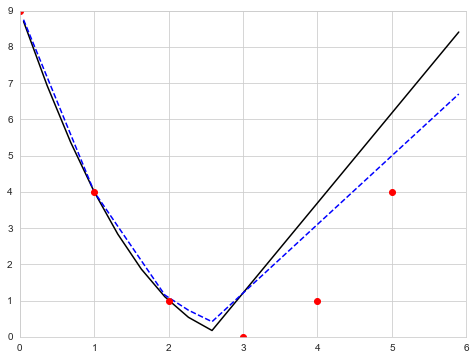

In [116]:
yi_scipy_interp = RegularGridInterpolator([x_known], f_known, 
                                          method='linear',bounds_error=False,fill_value=None)
output = yi_scipy_interp(x_true)
lin_fig(x_true,f_true,output)

In [117]:
output = np.stack(([np.empty_like(x_true)]*4), axis=1)
linear_interp.interp_1d_vec(x_known,f_known,x_true,output[:,0])
prep = linear_interp.interp_1d_prep(len(x_true))
linear_interp.interp_1d_vec_mon(prep,x_known,f_known,x_true,output[:,1])
#linear_interp.interp_1d_vec_mon_rep(prep,x_known,f_known,x_true,output[:,2])
#linear_interp.interp_1d_vec_mon_noprep(x_known,f_known,x_true,output[:,3])

#for i in range(4):
#    lin_fig(x_true,f_true,output[:,i])

In [118]:
x_known

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.])

In [119]:
x_true

array([0.05      , 0.36666667, 0.68333333, 1.        , 1.31666667,
       1.63333333, 1.95      , 2.26666667, 2.58333333, 5.9       ])

In [120]:
prep

array([1, 1, 1, 2, 2, 2, 2, 3, 3, 5])

In [22]:
from consav import linear_interp

In [50]:
grid1 = np.array([1, 2, 8, 3, 5],dtype=float)
linear_interp.binary_search(0,grid1.size,grid1,6.5)

3

In [45]:
grid1

array([1., 2., 8., 3., 5.])

# Logsum

In [4]:
@njit(parallel=True)
def logsum_loop(V, sigma):

    # 1. setup
    mxm = np.zeros((len(V),1))
    for i in range(len(V)):
        mxm[i,:] = np.max(V[i,:])
        
    cols = V.shape[1] # just equal to 2        
        
    # 3. logsum and probabilities
    if abs(sigma) > 1e-10:
        logsum = mxm + sigma*np.log(np.sum(np.exp((V - mxm*np.ones((1,cols)))/sigma), 
                                            axis=1)).reshape(mxm.shape)
        prob = np.exp((V - logsum*np.ones((1,cols)))/sigma)

    else:
        logsum = mxm
        prob = np.zeros(V.shape)
        for i in range(len(V)):
            if V[i,0] > V[i,1]:
                prob[i,0] = 1
            else:
                prob[i,1] = 1 

    return logsum,prob

In [5]:
@njit(parallel=True)
def logsum_vec(V, sigma): # supports only 2 columns in order to be implemented in numba
    
    # 1. setup
    #sigma = par.sigma_eta
    if len(V.shape) == 1: # to be compatible with simulate
        V = V.reshape(1,2)

    cols = V.shape[1] # just equal to 2

    # 2. maximum over the discrete choices
    mxm = np.maximum(V[:,0], V[:,1]).reshape(len(V),1)

    # 3. logsum and probabilities
    if abs(sigma) > 1e-10:
        logsum = mxm + sigma*np.log(np.sum(np.exp((V - mxm*np.ones((1,cols)))/sigma), 
                                            axis=1)).reshape(mxm.shape)
        prob = np.exp((V - logsum*np.ones((1,cols)))/sigma)

    else:
        logsum = mxm
        prob = np.zeros(V.shape)
        for i in range(len(V)):
            if V[i,0] > V[i,1]:
                prob[i,0] = 1
            else:
                prob[i,1] = 1 

    return logsum,prob

In [6]:
V = np.random.uniform(size=(1000,2))
sigma = 0.5

In [7]:
print(np.allclose(logsum_loop(V,sigma)[0],logsum_vec(V,sigma)[0]))
np.allclose(logsum_loop(V,sigma)[1],logsum_vec(V,sigma)[1])

True


True

In [8]:
funcs = [logsum_loop,logsum_vec]
argu = dict([(funcs[0], [V,sigma]),
             (funcs[1], [V,sigma])])
names = dict([(funcs[0], 'logsum_loop'),
             (funcs[1], 'logsum_vec')])
funs.my_timer(funcs,argu,names,unit='ns',Ntimes=100)

time unit is: ns
+-------------+-------------+-------------+-------------+-------------+-------+
|     func    |      lq     |    median   |     mean    |      uq     | neval |
+-------------+-------------+-------------+-------------+-------------+-------+
| logsum_loop | 31247138.98 | 31247854.23 | 32080287.93 | 31248867.51 | 100.0 |
|  logsum_vec |     0.0     |     0.0     |  156242.85  |     0.0     | 100.0 |
+-------------+-------------+-------------+-------------+-------------+-------+


In [19]:
@njit(parallel=True)
def prange_test(A):
    s = 0
    for i in prange(A.shape[0]):
        s += A[i] ** 3.5 - 100
    return s

@njit(parallel=True)
def range_test(A):
    s = 0
    for i in range(A.shape[0]):
        s += A[i] ** 3.5 - 100
    return s

In [24]:
A = np.random.uniform(size=1000000)
np.allclose(prange_test(A),range_test(A))

True

In [25]:
funcs = [prange_test,range_test]
argu = dict([(funcs[0], [A]),
             (funcs[1], [A])])
names = dict([(funcs[0], 'prange'),
             (funcs[1], 'range')])
funs.my_timer(funcs,argu,names,unit='ms',Ntimes=100)

time unit is: ms
+--------+-------+--------+-------+-------+-------+
|  func  |   lq  | median |  mean |   uq  | neval |
+--------+-------+--------+-------+-------+-------+
| prange | 15.62 | 15.63  | 22.67 | 31.25 | 100.0 |
| range  | 46.87 | 46.89  | 52.68 | 62.49 | 100.0 |
+--------+-------+--------+-------+-------+-------+


In [34]:
A = np.random.randint(5,size=10)
B = np.random.uniform(size=10)

In [38]:
B[A == 1]

array([0.8998617 , 0.48760187, 0.39399647, 0.72813904])

In [39]:
np.unique(A)

array([0, 1, 2, 3, 4])